In [1]:
__author__ = 'Simon Mork <simonmorkofficial@gmail.com>, <simonmork@uchicago.edu>'
__version__ = '20230709' # yyyymmdd; version datestamp of this notebook
__keywords__ = ['extragalactic', 'galaxies', 'image cutout', 'Milky Way']
__datasets__ = ['ls_dr9']

# Locating Milky Way Analogues in Legacy Surveys Data

<i>Simon Mork, Department of Astronomy and Astrophysics, University of Chicago<i>

### Table of Contents
* [Goals](#goals)
* [Summary](#summary)
* [Disclaimer & Attribution](#disclaimer)
* [Imports & Setup](#imports)
* [Data Access](#data)
* [Milky Way Analogue Selection](#analogues)
* [Image Cutout Generation](#cutouts)
* [Conclusion](#conclusion)
* [Resources and References](#references)

<a class="anchor" id="goals"></a>
# Goals
Using the photometric properties of the Milky Way as described in Licquia et al. 2016 [1], we aim to scrape the Legacy Surveys Data Release 9 (LSDR9) [2] North catalog for possible Milky Way analogues. Similar studies have been performed on SDSS galaxies, but the Legacy Surveys provide much deeper imaging data. We also leverage the photometric redshift catalog created for LSDR9 in order to locate Milky Way analogues to higher redshifts than many SDSS-identified Milky Way analogues.

<a class="anchor" id="summary"></a>
# Summary

Milky-Way analogues are a unique class of objects that allow us to test photometric measurements of our own galaxy in an external environment. Additionally, studying the local environment of such analogues allows us to determine where the Milky Way fits into the evolutionary history of the galaxies and the universe as a whole. In this notebook, we query the datalab servers for photometric and morphological information from LSDR9 and match it to associated photometric redshift information. We then apply an initial filtering step to remove stars by selecting sources that are best-fit with a galaxy profile (Sersic, de Vaucouleurs, Exponential) and select objects with valid dereddened photometry in all three photometric bandpasses (g,r,z). We then use the reported photometric redshifts to convert the observed magnitudes in each band into absolute magnitudes, factoring in appropriate K-corrections. We plot 2D histograms of our galaxy sample in color-magnitude and color-color space to verify that we have a reasonable sample of galaxies. We also scale the half light radius based on the appropriate angular diameter distance to convert to a physical distance at the redshift of a given galaxy. Finally we filter for Milky Way analogues with the appropriate size, absolute magnitude, and color within 1.5 sigma of the values provided in [1]. We use a slightly larger error boundary than is reported in [1] due to slight mismatches between the SDSS and DECam grz filters in the K-correction step. With a list of coordinates of Milky Way analogues in hand, we save a cutout for each galaxy from the Legacy Surveys viewer and plot them in a grid.

<a class="anchor" id="disclaimer"></a>
# Disclaimer & Attribution

If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445 
* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php
* This notebook makes use of the "K-corrections calculator" at http://kcor.sai.msu.ru/

This notebook was originally generated as part of the final project for ASTR285 "Science with Large Astronomical Surveys" at the University of Chicago.

<a class="anchor" id="imports"></a>
# Imports & Setup

In [2]:
import time
import urllib
import numpy as np
import pandas as pd
import warnings
from PIL import Image
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import pyplot as plt
from astropy.cosmology import LambdaCDM
from tqdm import tqdm
from dl import queryClient as qc
from dl.helpers.utils import convert

warnings.filterwarnings("ignore")


mpl.rcParams['font.size'] = 20                  #changes the plot font size to 20
mpl.rcParams['font.family'] = 'serif'           #changes the font family to serif
mpl.rcParams['font.serif'] = ['cmr10']          #changes the font to Computer Modern Roman (dependent on the font family)
mpl.rcParams['mathtext.fontset'] = 'cm'         #changes the mathtype font to Computer Modern Roman
mpl.rcParams["axes.formatter.use_mathtext"] = True
mpl.rcParams['figure.figsize'] = [8,8]          #changes the figure dimensions to [width, height]
mpl.rcParams['figure.dpi'] = 120                #changes the figure dpi to [value]
plt.rc('axes', unicode_minus=False)             #makes negative signs plot correctly in CMR

cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

In [3]:
def calc_kcor(filter_name, redshift, colour_name, colour_value):
    """
    K-corrections calculator in Python. See http://kcor.sai.msu.ru for the 
    reference. Available filter-colour combinations must be present in the 
    `coeff` dictionary keys.

    @type   filter_name: string    
    @param  filter_name: Name of the filter to calculate K-correction for, e.g. 
                         'u', 'g', 'r' for some of the SDSS filters, or 'J2', 
                         'H2', 'Ks2' for 2MASS filters (must be present in 
                         `coeff` dictionary)
    @type      redshift: float    
    @param     redshift: Redshift of a galaxy, should be between 0.0 and 0.5 (no
                         check is made, however)
    @type   colour_name: string    
    @param  colour_name: Human name of the colour, e.g. 'u - g', 'g - r', 
                         'V - Rc', 'J2 - Ks2' (must be present in `coeff` dictionary)
    @type  colour_value: float    
    @param colour_value: Value of the galaxy's colour, specified in colour_name    
    @rtype:              float
    @return:             K-correction in specified filter for given redshift and 
                         colour
    @version:            2012
    @author:             Chilingarian, I., Melchior. A.-L., and Zolotukhin, I.
    @license:            Simplified BSD license, see http://kcor.sai.msu.ru/license.txt

    Copyright 2009-2013 Chilingarian, I., Melchior. A.-L., and Zolotukhin, I. All rights reserved.
    **Modified to only include the colors calculated in this notebook**
    
    Usage example:
    
        >>> calc_kcor('g', 0.2, 'g - r', 1.1)
        0.5209713975999992
        >>> calc_kcor('Ic', 0.4, 'V - Ic', 2.0)
        0.310069919999993
        >>> calc_kcor('H', 0.5, 'H - K', 0.1)
        -0.14983142499999502
        
    """
    coeff = {

        'g_gr': [
            [0,0,0,0],
            [-2.45204,4.10188,10.5258,-13.5889],
            [56.7969,-140.913,144.572,57.2155],
            [-466.949,222.789,-917.46,-78.0591],
            [2906.77,1500.8,1689.97,30.889],
            [-10453.7,-4419.56,-1011.01,0],
            [17568,3236.68,0,0],
            [-10820.7,0,0,0],
        ],

        'r_gr': [
            [0,0,0,0],
            [1.83285,-2.71446,4.97336,-3.66864],
            [-19.7595,10.5033,18.8196,6.07785],
            [33.6059,-120.713,-49.299,0],
            [144.371,216.453,0,0],
            [-295.39,0,0,0],
        ],

        'z_rz': [
            [0,0,0,0],
            [0.669031,-3.08016,9.87081,-7.07135],
            [-18.6165,8.24314,-14.2716,13.8663],
            [94.1113,11.2971,-11.9588,0],
            [-225.428,-17.8509,0,0],
            [197.505,0,0,0],
        ],

    }

    c = coeff[filter_name + '_' + colour_name.replace(' - ', '')]
    kcor = 0.0

    for x, a in enumerate(c):
        for y, b in enumerate(c[x]):
            kcor += c[x][y] * redshift**x * colour_value**y

    return kcor

<a class="anchor" id="data"></a>
# Data Access

Here we query the LSDR9 catalog for relevant photometric and morphological data along with photometric redshifts. Since we are limited by the amount of data that any one query is allowed to take at any given time, we query in chunks and then concatenate them together.

In order to use the selection cell for arbitrary RA and Dec, change the following values.
* "SKIP" corresponds to the edge size of a square chunk in degrees. 20 accomplishes a large search area without timing out the SQL query.
* "RAMIN" minus half the value for "SKIP" will be the lower bound for RA for all objects identified.
* "DECMIN" minus half the value for "SKIP" will be the lower bound for Dec for all objects identified.
* "RACHUNKS" and "DECCHUNKS" correspond to the number of chunks with edge length "SKIP" to be selected from the catalog.

Example:

```
SKIP = 20
RAMIN,RACHUNKS = 100,2
DECMIN,DECCHUNKS = 50,2
```

This would select objects in a range from RA=90 to RA=130 and DEC=40 to DEC=80 using four square chunks in a 2x2 arrangement. It takes about 5 min to run.

In [4]:
SKIP = 20
RAMIN,RACHUNKS = 100,2
DECMIN,DECCHUNKS = 50,2

In [5]:
%%time
dfs=[]
query = """
SELECT t.ra, t.dec, t.type, t.dered_mag_g, t.dered_mag_r, t.dered_mag_z,
       t.shape_e1, t.shape_e2, t.shape_r, p.z_phot_mean
FROM ls_dr9.tractor as t, ls_dr9.photo_z as p
WHERE t.ls_id = p.ls_id
      AND p.z_phot_mean > 0
      AND p.z_phot_mean < 0.1
      AND t.ra > {}
      AND t.ra < {}
      AND t.dec > {}
      AND t.dec < {}
"""

for i in range(RAMIN,int(RAMIN+(SKIP*RACHUNKS)-(SKIP/2)),SKIP):
    for j in range(DECMIN,int(DECMIN+(SKIP*DECCHUNKS)-(SKIP/2)),SKIP):
        ra,dec,width=i,j,int(SKIP/2)
        t1=time.time()
        response = qc.query(adql = query.format(ra-width, ra+width, dec-width, dec+width), fmt='csv')
        dfs.append(convert(response))
        time.sleep(10)
        print('finished for',ra,dec,'after',round(time.time()-t1,3),'s')

finished for 100 50 after 116.486 s
finished for 100 70 after 72.602 s
finished for 120 50 after 104.527 s
finished for 120 70 after 71.068 s
CPU times: user 1.69 s, sys: 402 ms, total: 2.09 s
Wall time: 6min 4s


In [6]:
df=pd.concat(dfs,axis=0)
df

,ra,dec,type,dered_mag_g,dered_mag_r,dered_mag_z,shape_e1,shape_e2,shape_r,z_phot_mean
0,90.023998,59.998497,PSF,18.792042,18.052610,17.717468,0.0,0.0,0.0,0.072783
1,90.040295,59.991503,PSF,18.565180,18.057875,17.863860,0.0,0.0,0.0,0.083760
2,90.009870,59.984295,PSF,18.447742,18.168472,19.559580,0.0,0.0,0.0,0.003191
3,90.009889,59.982303,PSF,10.883052,11.142922,16.266294,0.0,0.0,0.0,0.011522
4,90.009991,59.980396,PSF,18.266466,18.327461,19.429096,0.0,0.0,0.0,0.003094
...,...,...,...,...,...,...,...,...,...,...
285328,119.745564,60.019124,PSF,15.418975,14.977608,15.255157,0.0,0.0,0.0,0.004346
285329,119.791854,60.016044,PSF,16.626465,16.094585,16.032104,0.0,0.0,0.0,0.015008
285330,119.724052,60.003472,PSF,16.448368,15.708855,15.553257,0.0,0.0,0.0,0.010176
285331,119.923703,60.016059,PSF,18.732128,18.234283,18.103193,0.0,0.0,0.0,0.083800


We filter to obtain only those sources which are robustly galaxies and also have valid observations in all three bands.

In [7]:
def noni(arrays):
    masterfilter=np.ones(len(arrays[0]),dtype='bool')
    filters=[]
    for i in range(len(arrays)):
        filters.append(~np.isnan(arrays[i]))
        filters.append(~np.isinf(arrays[i]))
    for i in range(len(filters)):
        masterfilter = masterfilter & filters[i]
    return masterfilter

g_mags = df['dered_mag_g']
r_mags = df['dered_mag_r']
z_mags = df['dered_mag_z']
ninfilter = noni([g_mags,r_mags,z_mags])
typfilter = (df['type'] == 'DEV') | (df['type'] == 'EXP') | (df['type'] == 'SER')

data=df[ninfilter & typfilter]
print(len(data),'galaxies after quality cuts')

136659 galaxies after quality cuts


We apply relevant K-corrections to data and also scale the half-light radius by the appropriate angular diameter distance. We note that the K-corrections were derived for the SDSS bandpasses, which are slightly different than the DECam bandpasses. We account for this later on by broadening our selection region.

In [8]:
g = data['dered_mag_g']
r = data['dered_mag_r']
z = data['dered_mag_z']
g_r = g - r
r_z = r - z

redshifts = np.asarray(data['z_phot_mean'])
abs_e = (data['shape_e1']**2+data['shape_e2']**2)**0.5
a = (1-abs_e)/(1+abs_e)

half_light_rad = np.pi/180/60/60*data['shape_r']
half_light_kpc = cosmo.angular_diameter_distance(z=redshifts).value*1000*half_light_rad

cosmo_correction = cosmo.distmod(z=redshifts).value + 5*np.log10(cosmo.h)
M_g = g - calc_kcor('g', data['z_phot_mean'], 'g - r', g_r) - cosmo_correction
M_r = r - calc_kcor('r', data['z_phot_mean'], 'g - r', g_r) - cosmo_correction
M_z = z - calc_kcor('z', data['z_phot_mean'], 'r - z', r_z) - cosmo_correction

Color-magnitude and color-color plot for verification of galaxy population.

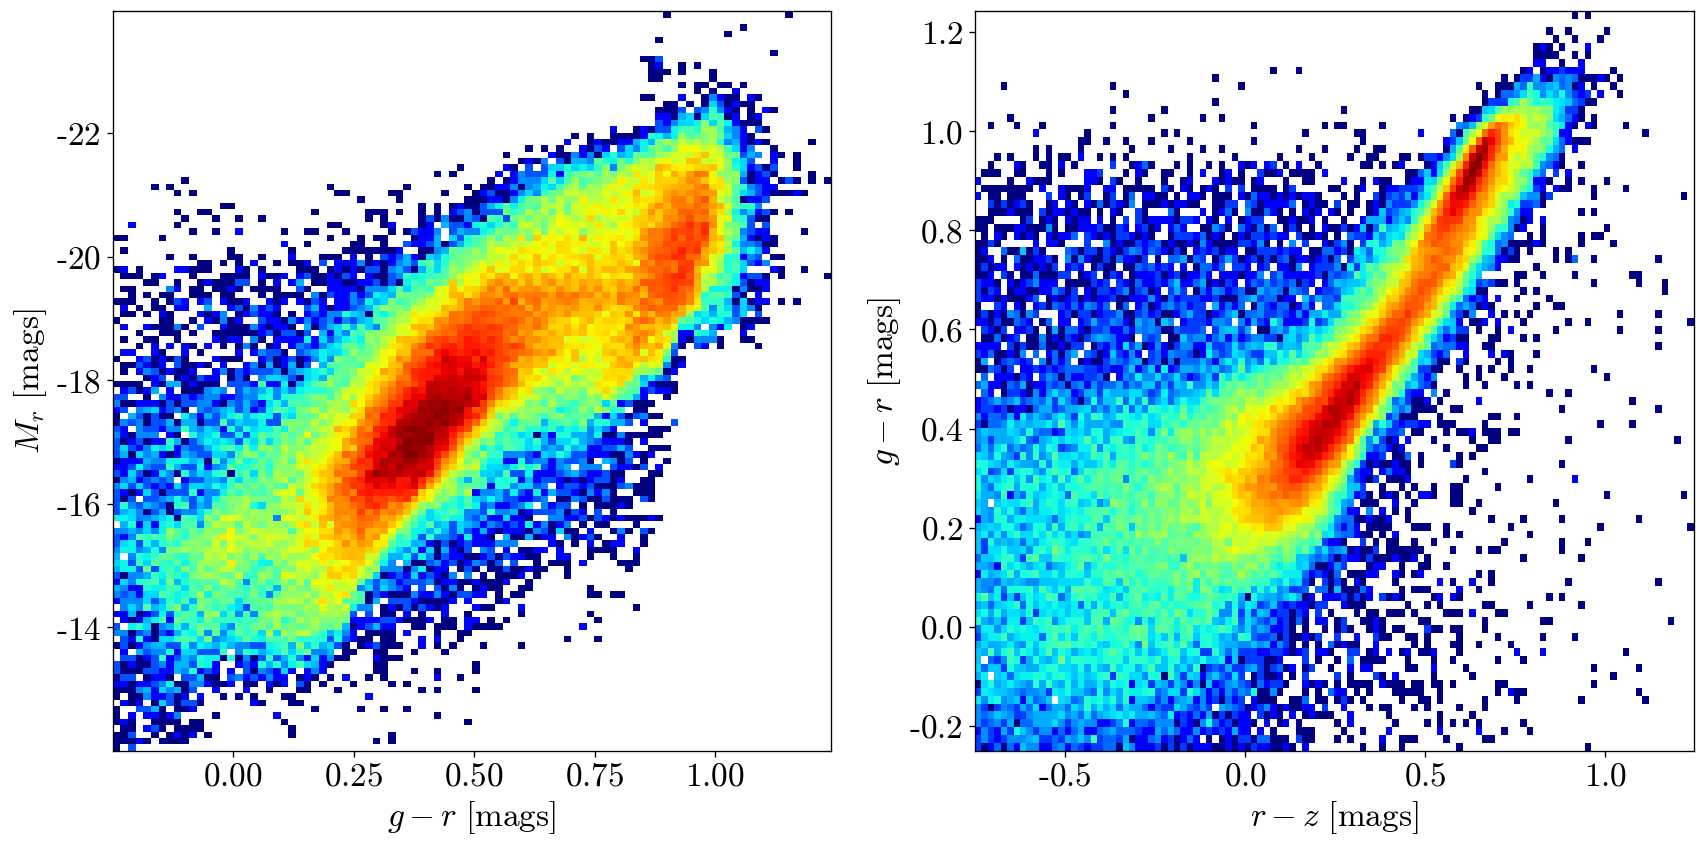

In [17]:
fig=plt.figure(figsize=(17,8),dpi=120)
axs=GridSpec(1,2)
ax1,ax2=fig.add_subplot(axs[0]),fig.add_subplot(axs[1])

colorcut = (g_r>-0.25) & (g_r<1.25) & (r_z>-0.75) & (r_z<1.25) & (M_r>-24) & (M_r<-12)
g_r_cut=g_r[colorcut]
r_z_cut=r_z[colorcut]
g_cut=g[colorcut]
r_cut=r[colorcut]
M_r_cut=M_r[colorcut]

g_r_bins,junk=np.histogram(g_r_cut,bins='auto')
r_z_bins,junk=np.histogram(r_z_cut,bins='auto')
g_bins,junk=np.histogram(g_cut,bins='auto')
r_bins,junk=np.histogram(g_cut,bins='auto')
M_r_bins,junk=np.histogram(M_r_cut,bins='auto')

ax1.hist2d(g_r_cut,M_r_cut,bins=[len(g_r_bins),len(M_r_bins)],cmap='jet',norm=LogNorm())
ax2.hist2d(r_z_cut,g_r_cut,bins=[len(r_z_bins),len(g_r_bins)],cmap='jet',norm=LogNorm())

ax1.set_xlabel(r'$g-r \ [\rm mags]$')
ax1.set_ylabel(r'$M_r \ [\rm mags]$')
ax1.invert_yaxis()
ax2.set_xlabel(r'$r-z \ [\rm mags]$')
ax2.set_ylabel(r'$g-r \ [\rm mags]$')
plt.show()

<a class="anchor" id="analogues"></a>
# Milky Way Analogue Selection

Apply filters based on the best-fit values from [1] to identify Milky Way analogues.

In [10]:
# Measured values and upper/lower uncertainties
# [value, upper, lower]
# range = [value+upper, value-lower]

# MW size measurement from [1]
MW_rh_kpc = (4.4, 0.2, 0.2)

# MW absolute magnitude measurements and uncertainties from Table 7 of [1]
MW_M_g = (-20.33, 0.42, 0.43)
MW_M_r = (-20.97, 0.37, 0.40)
MW_M_z = (-21.53, 0.36, 0.39)

# MW color index from Table 7 of [1]
MW_g_r = (0.678, 0.069, 0.057)

In [11]:
# Broaden the selection region to account for the SDSS-based K-correction
sigma=1.5

half_light_filter = (half_light_kpc < MW_rh_kpc[0]+MW_rh_kpc[1]*sigma) & (half_light_kpc > MW_rh_kpc[0]-MW_rh_kpc[2]*sigma)
g_magnitude_filter = (M_g < MW_M_g[0]+MW_M_g[1]*sigma) & (M_g > MW_M_g[0]-MW_M_g[2]*sigma)
r_magnitude_filter = (M_r < MW_M_r[0]+MW_M_r[1]*sigma) & (M_r > MW_M_r[0]-MW_M_r[2]*sigma)
z_magnitude_filter = (M_z < MW_M_z[0]+MW_M_z[1]*sigma) & (M_z > MW_M_z[0]-MW_M_z[2]*sigma)
color_filter = (g_r < MW_g_r[0]+MW_g_r[1]*sigma) & (g_r > MW_g_r[0]-MW_g_r[2]*sigma)
projection_filter = a > 0.5
red_filter = data['z_phot_mean'] < 0.1

milkyway_filter = half_light_filter   & \
                  g_magnitude_filter  & \
                  r_magnitude_filter  & \
                  z_magnitude_filter  & \
                  color_filter        & \
                  red_filter          & \
                  projection_filter

mw_data = (data[milkyway_filter]).reset_index()
print(len(mw_data),'Milky Way analogues found')

102 Milky Way analogues found


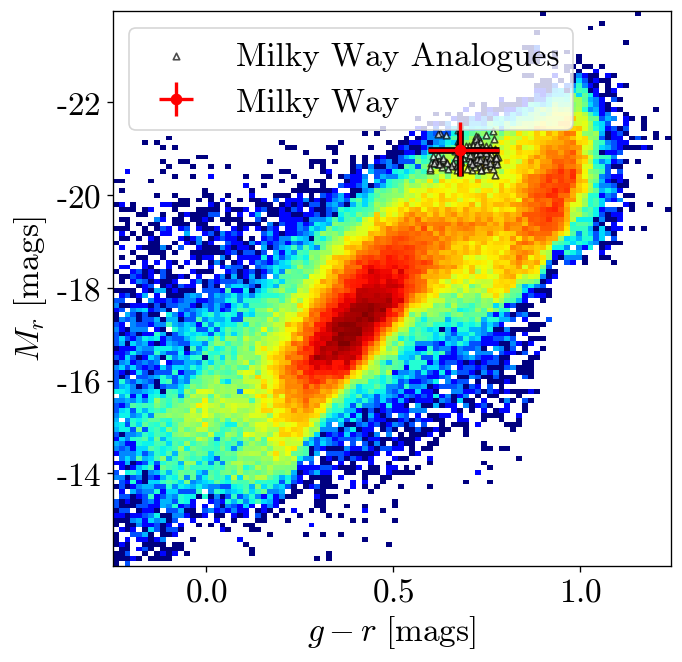

In [18]:
# Plot the selected MW analogues and MW values on the previous color-magnitude histogram.
fig=plt.figure(figsize=(6,6), dpi=120)
plt.hist2d(g_r_cut, M_r_cut, bins=[len(g_r_bins), len(M_r_bins)], cmap='jet', norm=LogNorm())
plt.errorbar(MW_g_r[0], MW_M_r[0], 
             xerr=sigma*np.array([[MW_g_r[2], MW_g_r[1]]]).T, 
             yerr=sigma*np.array([[MW_M_r[2], MW_M_r[1]]]).T, 
             c='r', marker='o', ls='', capthick=2, elinewidth=2, zorder=10,
             label="Milky Way")
plt.errorbar(MW_g_r[0], MW_M_r[0], 
             xerr=sigma*np.array([[MW_g_r[2], MW_g_r[1]]]).T, 
             yerr=sigma*np.array([[MW_M_r[2], MW_M_r[1]]]).T, 
             c='k', marker='o', ls='', capthick=4, elinewidth=4, zorder=4)
plt.scatter(g_r[milkyway_filter], M_r[milkyway_filter],
            c='white', marker='^', s=15, alpha=0.7, edgecolors='black',
            label='Milky Way Analogues')

plt.legend(loc='upper left')
plt.gca().set_xlabel(r'$g-r \ [\rm mags]$')
plt.gca().set_ylabel(r'$M_r \ [\rm mags]$')
plt.gca().invert_yaxis()

<a class="anchor" id="cutouts"></a>
# Image Cutout Generation

Plotting code to generate a random subset of cutouts. This cell takes about 3 min to run.

100%|██████████| 90/90 [02:43<00:00,  1.81s/it]


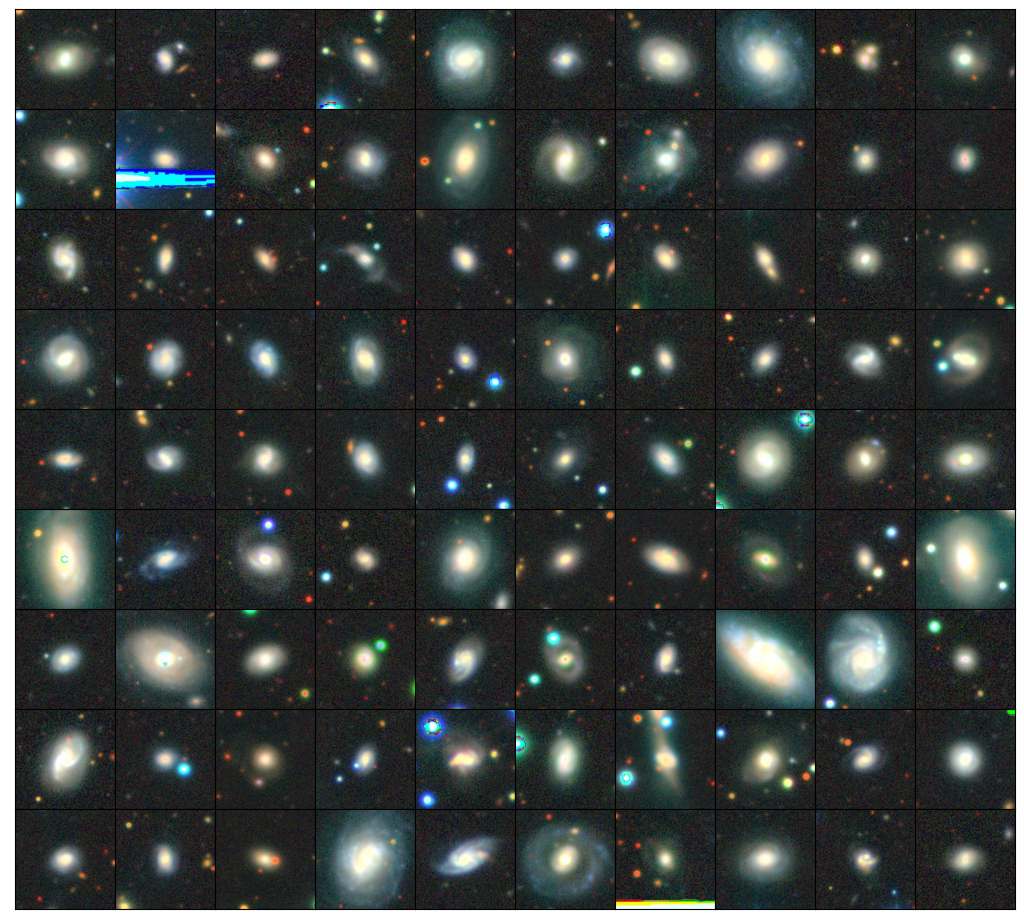

In [13]:
zoom=2
nrow,ncol=int(np.floor(np.sqrt(len(mw_data))))-1,int(np.floor(np.sqrt(len(mw_data))))
fig=plt.figure(figsize=(ncol+1,nrow+1),dpi=100)
gs=GridSpec(nrow,ncol,wspace=0.0,hspace=0.0,\
                     top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),\
                     left=0.5/(ncol+1), right=1-0.5/(ncol+1))

imgs,urls = [],[]
for i in tqdm(np.random.choice(np.linspace(0,len(mw_data)-1,len(mw_data)),size=int(nrow*ncol),replace=False)):
    i = int(i)
    imgquery = 'https://www.legacysurvey.org/viewer/jpeg-cutout?ra={}&dec={}&layer=ls-dr9&pixscale=0.262'
    urls.append(imgquery.format(mw_data['ra'][i],mw_data['dec'][i]))
    urllib.request.urlretrieve(imgquery.format(mw_data['ra'][i],mw_data['dec'][i]),str(round(mw_data['ra'][i],8))+str(round(mw_data['dec'][i],8))+".png")
    img = np.asarray(Image.open(str(round(mw_data['ra'][i],8))+str(round(mw_data['dec'][i],8))+".png"))
    imgs.append(img)
    time.sleep(1)

counter=0
for row in range(nrow):
    for column in range(ncol):
        ax=plt.subplot(gs[row,column])
        ax.set_xticks([])
        ax.set_yticks([])
        index=counter
        counter+=1
        tempim=imgs[index]
        ax.imshow(tempim[int(127-np.round(tempim.shape[0]/(zoom+1),0)+1):int(127+np.round(tempim.shape[0]/(zoom+1),0)),\
                  int(127-np.round(tempim.shape[0]/(zoom+1),0)+1):int(127+np.round(tempim.shape[0]/(zoom+1),0))])
        
#fig.set_facecolor('white')
plt.show()
#fig.savefig('CLUSTER_GRID_2.png', dpi=240, facecolor=fig.get_facecolor(), transparent=False)

It is interesting to see many spiral galaxies showing up in this sample, despite the fact that we did not put any morphological selection on galactic structure.

<a class="anchor" id="conclusion"></a>
# Conclusion

We have demonstrated that it is possible to identify galaxies that are similar to the Milky Way using photometric properties. Future steps for this project could include cross-checking photometric redshifts with known SDSS spectroscopic redshifts, as well as characterizing the color of the Milky Way in r-z as well (which is not provided in [1]). It could also be interesting to perform a more detailed morphological analysis of the candidate analogues to better match the Milky Way morphology.

<a class="anchor" id="references"></a>
# Resources and References

[1] Licquia, T. C. and Newman, J. A., “Sizing Up the Milky Way: A Bayesian Mixture Model Meta-analysis of Photometric Scale Length Measurements”, <i>The Astrophysical Journal</i>, vol. 831, no. 1, 2016. doi:10.3847/0004-637X/831/1/71

[2] Dey, A., “Overview of the DESI Legacy Imaging Surdoi:10.3847/0004-637X/831/1/71veys”, <i>The Astronomical Journal</i>, vol. 157, no. 5, 2019. doi:10.3847/1538-3881/ab089d.

[3] Chilingarian, I., Zolotukhin, I. 2012: A universal ultraviolet-optical colour-colour-magnitude relation of galaxies, MNRAS, v. 419, p. 1727 (also arXiv:1102.1159)

[4] Chilingarian, I., Melchior, A.-L., Zolotukhin, I. 2010: Analytical approximations of K-corrections in optical and near-infrared bands, MNRAS, v. 405, p. 1409 (also arXiv:1002.2360)